In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
from copy import deepcopy
import jax
import fedjax
from datetime import datetime

from hyperparameter_tuning.non_IID_setting.serverside.federated_library.distributions import to_ClientData
from hyperparameter_tuning.non_IID_setting.serverside.federated_library.dataset_loader import load_tf_dataset
from hyperparameter_tuning.non_IID_setting.serverside.federated_library.train_fed_avg import train_fed_avg
from constants import DATASETS, SKEWS
from read_data import get_client_res
from heuristic_funcs import aggregate_results

ModuleNotFoundError: No module named 'federated_library'

In [3]:
def fedavg_eval_heur(params, ds, test_split, ds_info, display):
    runs = params['runs']
    num_clients = params['num_clients']
    skews = params['skews']

    nr_settings = len(num_clients) * len(skews)

    print(
        f'Grid search on {nr_settings} settings, {nr_settings * runs} with folds')

    count = 0

    res = []

    for n in num_clients:
        ds_info['num_clients'] = n
        for skew in skews:
            hps_test, accs_test, best_acc_test, ratios_test = get_client_res(
                dataset=params["dataset"], skew=skew,
                nr_parties=n, hyper_param=params["hp"],
                type_of_skew=ds_info["skew_type"]
            )
            agg_params = aggregate_results(
                hps_test, accs_test, best_acc_test, ratios_test,
                hyper_param=params["hp"],
                type_of_skew=params["skew_type"], v=1
            )
            params_r = deepcopy(params)
            params_r["skew"] = skew
            params_r["num_clients"] = n

            params_r.update(agg_params)

            print(f'Training with params : {params_r}')

            for _ in range(runs):
                run_res = train_fed_avg(
                    params_r, ds, test_split, ds_info, display=display
                )['accuracy']
                print(count, run_res)

                res.append((run_res, deepcopy(params_r)))
                count += 1

    return res


MNIST: starting at 2021-10-21 08:56:37.518741


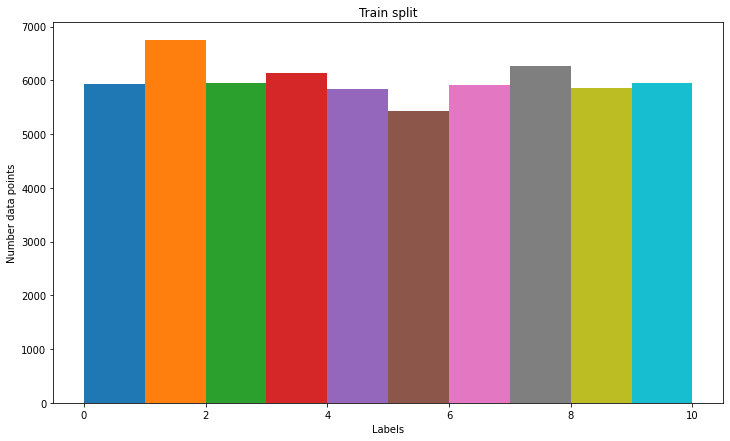

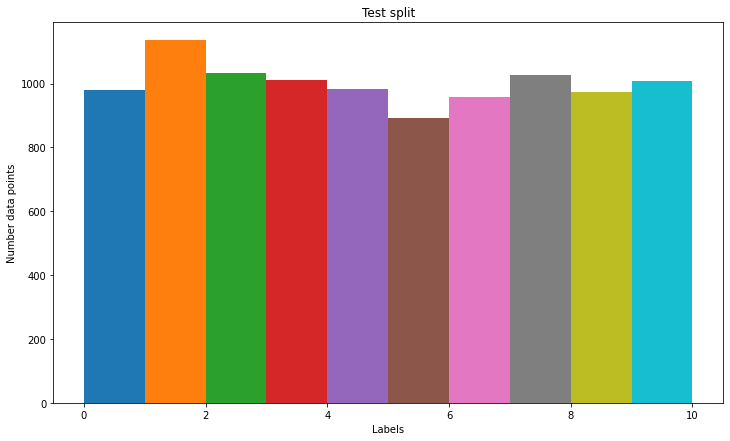

/home/xavi_oliva/Documents/UCB/semester_project/sp_venv/lib/python3.6/site-packages/tensorflow_federated/python/simulation/datasets/serializable_client_data.py:112: UserWarning: Creating resources inside a function passed to Dataset.flat_map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  example_dataset = nested_dataset.flat_map(self.serializable_dataset_fn)


Grid search on 6 settings, 6 with folds
Training with params : {'act_fn': <jax._src.custom_derivatives.custom_jvp object at 0x7f35902b1be0>, 'client_lr': 0.021374999999999998, 'server_lr': 0.03162277660168379, 'client_momentum': 0.3, 'server_momentum': 0.9, 'batch_size': 16, 'epochs_per_round': 2, 'rounds': 30, 'runs': 1, 'num_clients': 10, 'skews': [0.1, 1.0, 5.0], 'skew_type': 'label', 'dataset': 'MNIST', 'hp': 'client_lr', 'skew': 0.1}
Label skew


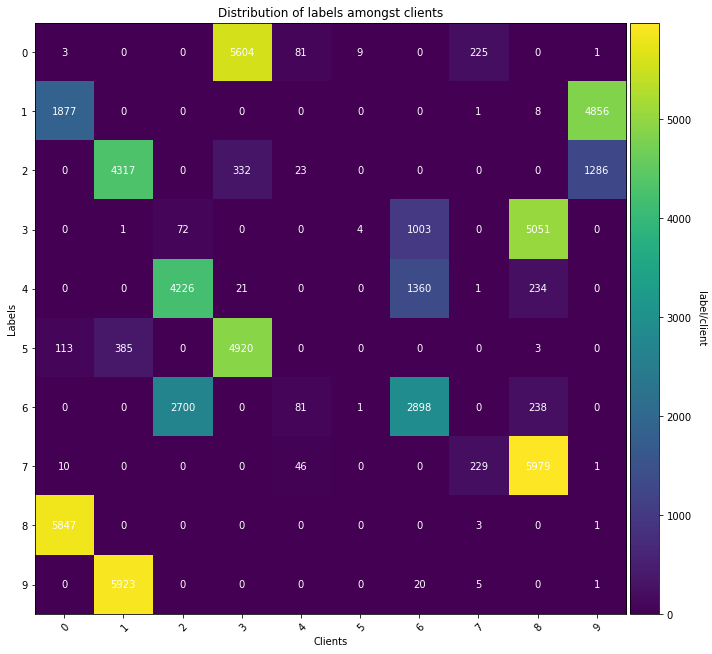

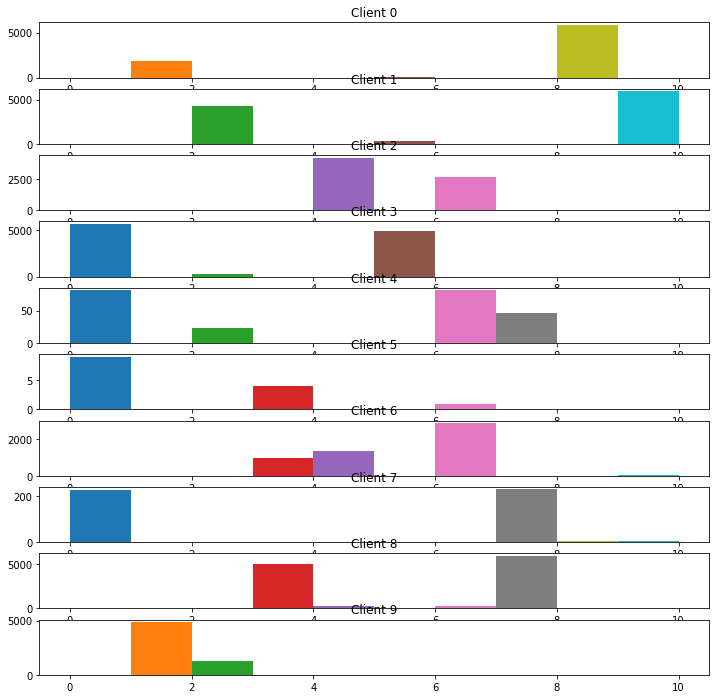

AttributeError: 'NoneType' object has no attribute 'shape'

In [4]:
# Evaluate heuristic performance

skew_type = "label"
# TODO: solve feature skew error
hp = "client_lr"

for dataset in DATASETS:
    print(f"{dataset}: starting at {datetime.now()}")
    experiment_name = f"results/non-iid_{skew_type}_skew_{dataset}"

    ds, (x_test, y_test), ds_info = load_tf_dataset(dataset_name=dataset, skew_type=skew_type, decentralized=False,
                                                    display=True)
    test_split = fedjax.create_tf_dataset_for_clients(to_ClientData([x_test], [y_test], ds_info, train=False),
                                                      ['0']).batch(50)

    params = dict(
        act_fn=jax.nn.relu,
        client_lr=0.01,
        server_lr=math.sqrt(0.001),
        client_momentum=0.3,
        server_momentum=0.9,
        batch_size=16,
        epochs_per_round=2,
        rounds=30,
        runs=1,
        num_clients=[10, 20],
        skews=SKEWS[skew_type],
        skew_type=skew_type,
        dataset=dataset,
        hp=hp
    )
    print(fedavg_eval_heur(params, ds, test_split, ds_info, display=True))
